# Zero shot anomaly detection on MVTec

In [1]:
import os
import math
import argparse
from tqdm import tqdm

import cv2
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt
import random

from Datasets import DATASET_REGISTRY

In [2]:
def load_dinov3_local(repo_dir, model_name, weights, device):
    """
    Load a local DINOv3 model via torch.hub (repo_dir points to the dinov3 repo).
    model_name: e.g. 'dinov3_vits16' or 'dinov3_vitl16'
    weights: path to local checkpoint
    """
    model = torch.hub.load(repo_dir, model_name, source='local', weights=weights)
    model.to(device)
    model.eval()
    return model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

Dino = load_dinov3_local("dinov3", "dinov3_vits16", "dinov3_vits16_pretrain_lvd1689m-08c60483.pth", device)

cuda:0


In [3]:
def prepare_data_from_registry(dataset_name, category, batch_size, device, resize=512, imagesize=512, **kwargs):
    dataset_name = dataset_name.lower()
    if DATASET_REGISTRY is None:
        raise RuntimeError("DATASET_REGISTRY not available. Provide images differently.")
    if dataset_name not in DATASET_REGISTRY:
        raise ValueError(f"Unsupported dataset: {dataset_name}")
    dataset_cls, split_cls, root_path = DATASET_REGISTRY[dataset_name]
    test_dataset = dataset_cls(source=root_path, split=split_cls.TEST, classname=category, resize=resize, imagesize=imagesize)
    loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)
    return loader

dataloader = prepare_data_from_registry("mvtec", "metal_nut", 4, device)

mvtec_anomaly_detection/metal_nut/test


In [4]:
def get_sample_from_registry(dataset_name, category, resize=512, imagesize=512, **kwargs):
    dataset_name = dataset_name.lower()
    if DATASET_REGISTRY is None:
        raise RuntimeError("DATASET_REGISTRY not available. Provide images differently.")
    if dataset_name not in DATASET_REGISTRY:
        raise ValueError(f"Unsupported dataset: {dataset_name}")
    dataset_cls, split_cls, root_path = DATASET_REGISTRY[dataset_name]
    test_dataset = dataset_cls(source=root_path, split=split_cls.TEST, classname=category, resize=resize, imagesize=imagesize)
    idx = random.randint(0, len(test_dataset) - 1)
    sample = test_dataset[idx]   # returns dict
    return sample

test_image = get_sample_from_registry("mvtec", "metal_nut")

mvtec_anomaly_detection/metal_nut/test


mvtec_anomaly_detection/metal_nut/test


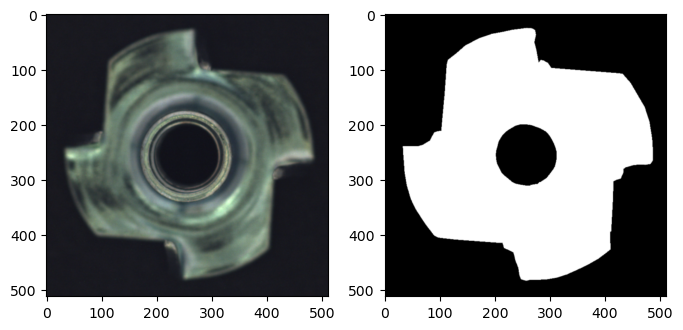

In [5]:
test_image = get_sample_from_registry("mvtec", "metal_nut")

fig, ax = plt.subplots(1,2, figsize=(8,4))

image = test_image['image']
mask = test_image['mask']

ax[0].imshow(image.permute(1,2,0).cpu())
ax[1].imshow(mask.squeeze().cpu(), cmap='gray')
plt.show()

mvtec_anomaly_detection/metal_nut/test
mvtec_anomaly_detection/metal_nut/test
mvtec_anomaly_detection/metal_nut/test
mvtec_anomaly_detection/metal_nut/test
mvtec_anomaly_detection/metal_nut/test


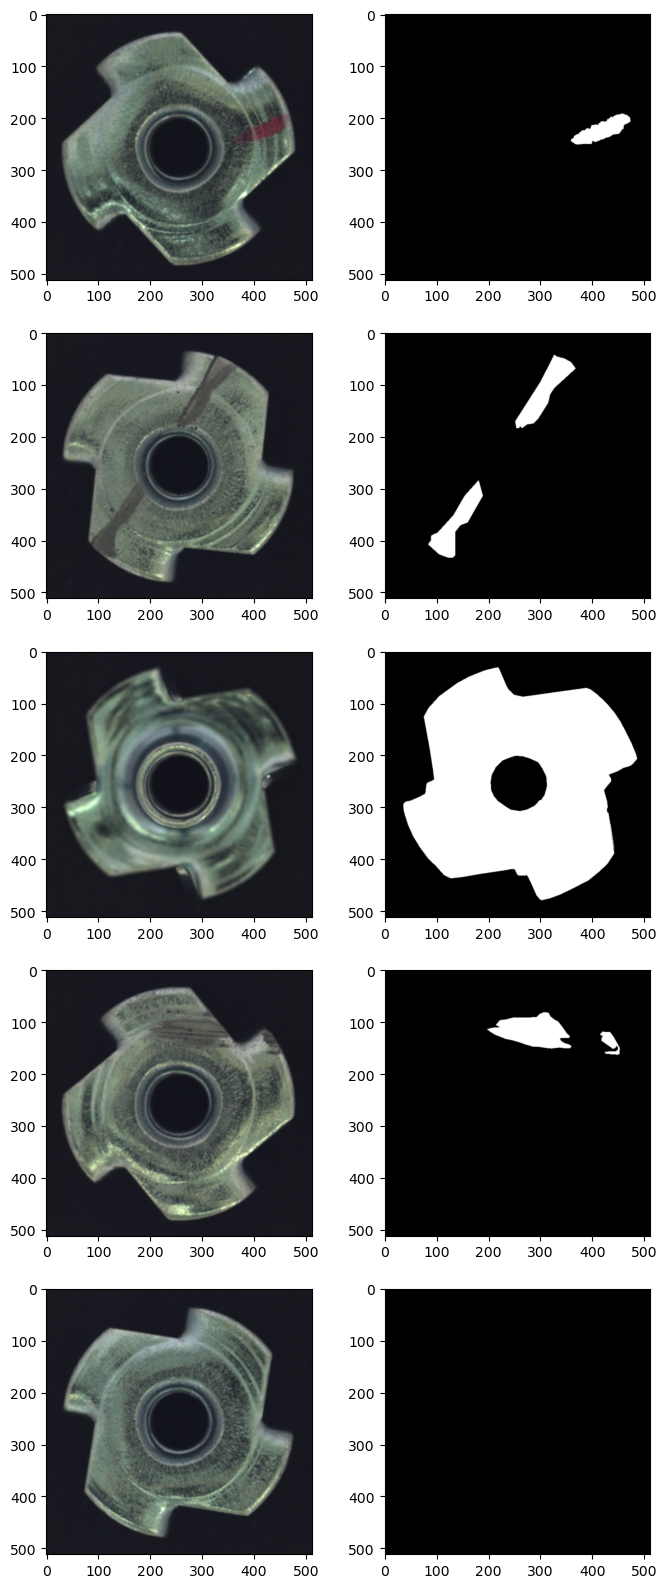

In [6]:
fig, ax = plt.subplots(5,2, figsize=(8,20))

for i in range(5):

    sample = get_sample_from_registry("mvtec", "metal_nut")
    batch = {'image': sample['image'].unsqueeze(0), 'mask': sample['mask'].unsqueeze(0)}
    image = batch['image']
    mask = batch['mask']

    ax[i,0].imshow(image[0].permute(1,2,0).cpu())
    ax[i,1].imshow(mask[0].squeeze().cpu(), cmap='gray')

plt.show()

In [7]:
all_labels = []
all_embeddings = []
torch.cuda.empty_cache()
Dino.eval()
for batch in tqdm(dataloader):
    data = batch['image']
    labels = batch['mask']
    new_labels = labels.numpy().tolist()
    all_labels += new_labels
    data = data.to(device)
    embeddings = Dino(data.to(device))
    all_embeddings.append(np.reshape(embeddings.detach().cpu().numpy(),(len(new_labels),-1)))
all_embeddings = np.vstack(all_embeddings)

100%|██████████| 29/29 [00:04<00:00,  6.41it/s]


In [8]:
all_embeddings[0].shape

(384,)

mvtec_anomaly_detection/metal_nut/test
mvtec_anomaly_detection/metal_nut/test/color/010.png


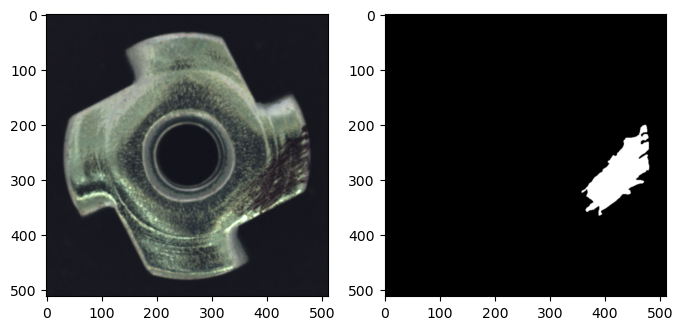

In [9]:
from DataHandler import DataSampler

sample = DataSampler.get_sample_from_registry("mvtec", "metal_nut")

fig, ax = plt.subplots(1,2, figsize=(8,4))

image = sample['image']
mask = sample['mask']

print(sample["image_path"])

ax[0].imshow(image.permute(1,2,0).cpu())
ax[1].imshow(mask.squeeze().cpu(), cmap='gray')
plt.show()

In [10]:
all_good_samples = DataSampler.get_all_good_samples_from_category("mvtec", "bottle")
all_good_samples[0]

mvtec_anomaly_detection/bottle/train
Found 209 good samples in category 'bottle' of dataset 'mvtec'.


{'image': tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 'mask': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.,

In [11]:
good_images = [sample['image'].unsqueeze(0) for sample in all_good_samples]
good_images = torch.cat(good_images, dim=0)
good_masks = [sample['mask'].unsqueeze(0) for sample in all_good_samples]
good_masks = torch.cat(good_masks, dim=0)

In [12]:
good_masks[0].shape

torch.Size([1, 512, 512])

In [13]:
sample["image"].shape

torch.Size([3, 512, 512])

### Philip method

In [14]:
from torchvision.transforms import v2
from PIL import Image

def make_transform(resize_size: int = 256):
    to_tensor = v2.ToImage()
    resize = v2.Resize((resize_size, resize_size), antialias=True)
    to_float = v2.ToDtype(torch.float32, scale=True)
    normalize = v2.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    )
    return v2.Compose([to_tensor, resize, to_float, normalize])

pre_process = make_transform(resize_size = 256) #Could change size if we want

# image_tensor = pre_process(sample["image"])
# image_tensor_normal = good_images[0]
# image_tensor_ground_truth = good_masks[0]

In [15]:
model = Dino
model.to(device)
model.eval()

def visualize_patch_attention(image_tensor_broken, image_tensor_normal, image_gnd_truth, model, category):
    with torch.no_grad():
        features_dict = model.forward_features(image_tensor_broken)  # Usually outputs a tensor [1, 768] for vitb16
        #Also for the non-broken one
        features_dict_normal = model.forward_features(image_tensor_normal)



    #Now we have a dictionary, with clstoken and a tensor. We only want the tensor.
    features = features_dict["x_norm_patchtokens"]


    # print(f'Features shape {features.shape}')
    # print(f'Features other than patchtokens shape {features_dict["x_prenorm"].shape}')
    # print(features[0, :10])  # Print first 10 feature values

    #Save as a np.array, and then resize it, and show it.
    B, N, C = features.shape

    # 2. Reshape [16, 16, 384]
    H = W = int(N ** 0.5)
    tokens_grid = features.reshape(1, H, W, C)

    # 3. Turn each 384-d vector into a scalar (L2 norm)
    #heatmap = torch.norm(tokens_grid, dim=-1)  # shape [1, 16, 16]
    #Try the mean intead.
    #heatmap = tokens_grid.mean(dim=-1)
    #Try Variance
    #heatmap = tokens_grid.var(dim=-1)

    #Try similaitry to CLS tokens.
    cls = features_dict["x_norm_clstoken"]  # [1,384]
    cls = cls.expand_as(features[:, :N])

    cls_norm = features_dict_normal["x_norm_clstoken"]
    cls_norm = cls_norm.expand_as(features[:, :N])

    #sim = torch.einsum("nc,nc->n", features.squeeze(0), cls.squeeze(0)) #Dot product for each patch vs. the global cls token.
    #Try cosine similarity instead:
    sim = F.cosine_similarity(
        features.squeeze(0), 
        cls.squeeze(0), 
        dim=-1
    )

    #Now try cosine similarity between cls tokens from a non-broken bottle, and patch tokens from a broken one.
    sim_norm = F.cosine_similarity(
        features.squeeze(0),
        cls_norm.squeeze(0),
        dim =-1
    )


    heatmap = sim.reshape(H, W)

    heatmap_cls_norm = sim_norm.reshape(H,W)

    # 4. Normalize to [0, 1]
    heatmap_norm = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

    heatmap_cls_norm_norm = (heatmap_cls_norm - heatmap_cls_norm.min()) / (heatmap_cls_norm.max() - heatmap_cls_norm.min())

    # 5. Upsample from 16×16 to 256×256 using PyTorch
    heatmap_up = F.interpolate(
        heatmap_norm.unsqueeze(0).unsqueeze(0),  
        size=(256, 256),
        mode="bicubic",
        align_corners=False
    )[0, 0].cpu().numpy()

    #Vs. cls from normal bottle.
    heatmap_up_cls_norm = F.interpolate(
        heatmap_cls_norm_norm.unsqueeze(0).unsqueeze(0),  
        size=(256, 256),
        mode="bicubic",
        align_corners=False
    )[0, 0].cpu().numpy()


    # 6. Convert original image to numpy (resize to 256)
    image_np = np.array(image_broken.resize((256, 256)))

    #Also, print the normal pic.
    image_norm_np = np.array(image_norm.resize((256, 256)))

    #Ground truth pic:
    image_gnd_truth_np = np.array(image_gnd_truth.resize((256, 256)))

    # 7. Apply matplotlib colormap (jet)
    colormap = plt.cm.jet
    heatmap_color = colormap(heatmap_up)[:, :, :3]  # remove alpha channel
    heatmap_color = (heatmap_color * 255).astype(np.uint8)

    #Copy for the other picture.
    colormap2 = plt.cm.jet
    heatmap_color2 = colormap(heatmap_up_cls_norm)[:, :, :3]
    heatmap_color2 = (heatmap_color2*255).astype(np.uint8)


    # 8. Blend heatmap + image
    overlay_image_np = (0.6 * image_np + 0.4 * heatmap_color).astype(np.uint8)
    overlay_image_np_cls_norm = (0.6 * image_np + 0.4 * heatmap_color2).astype(np.uint8)
    # combined = heatmap_up_cls_norm-heatmap_up
    # print(heatmap_up_cls_norm.shape)
    # print(combined.shape)
    # overlay_combined = (0.6 * image_np + 0.4 * combined).astype(np.uint8)

    # 9. Visualize
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(image_np); plt.axis("off")
    plt.subplot(1, 3, 2); plt.title("Patch heatmap"); plt.imshow(heatmap_up, cmap='jet'); plt.axis("off")
    plt.subplot(1, 3, 3); plt.title("Overlay on anomaly"); plt.imshow(overlay_image_np); plt.axis("off")
    plt.show()

    # 10. Visulatize second pic with normal cls_tokens
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1); plt.title(f"Ground truth"); plt.imshow(image_gnd_truth_np); plt.axis("off")
    plt.subplot(1, 3, 2); plt.title("CLS norm"); plt.imshow(heatmap_up_cls_norm, cmap='jet'); plt.axis("off")
    plt.subplot(1, 3, 3); plt.title("Overlay on anomaly"); plt.imshow(overlay_image_np_cls_norm); plt.axis("off")
    plt.show()


    # 11. Visulatize second pic with normal cls_tokens and difference with broken broken picture.
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1); plt.title(f"Ground truth"); plt.imshow(image_gnd_truth_np); plt.axis("off")
    plt.subplot(1, 3, 2); plt.title("CLS norm - patch heatmap"); plt.imshow(heatmap_up_cls_norm-heatmap_up, cmap='jet'); plt.axis("off")
    plt.subplot(1, 3, 3); plt.title("Overlay on anomaly"); plt.imshow(overlay_image_np); plt.axis("off")
    plt.show()

    # #12. Visualize the ground truth.
    # plt.figure(figsize=(12, 4))
    # plt.subplot(1, 3, 1); plt.title(f"Broken {category}"); plt.imshow(image_np); plt.axis("off")
    # plt.subplot(1, 3, 2); plt.title("Patch heatmap"); plt.imshow(heatmap_up_cls_norm-heatmap_up, cmap='jet'); plt.axis("off")
    # plt.subplot(1, 3, 3); plt.title(f"Ground truth"); plt.imshow(image_gnd_truth_np); plt.axis("off")
    # plt.show()

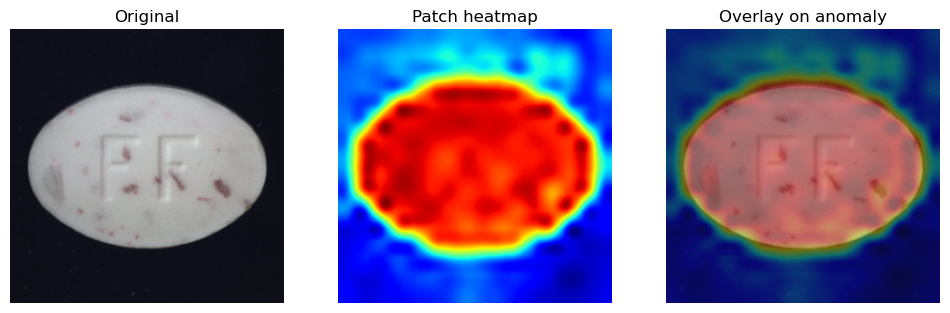

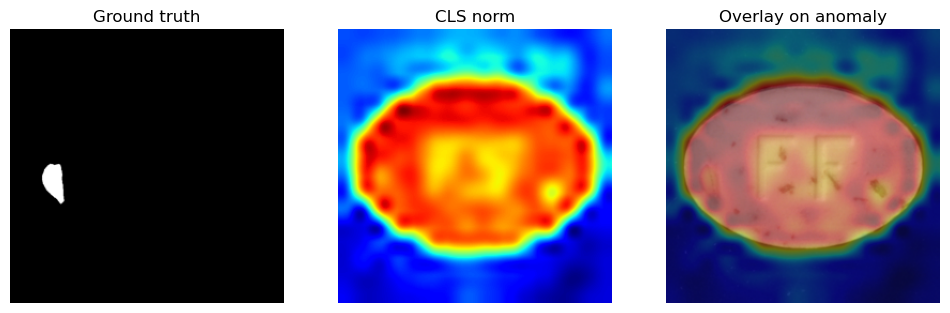

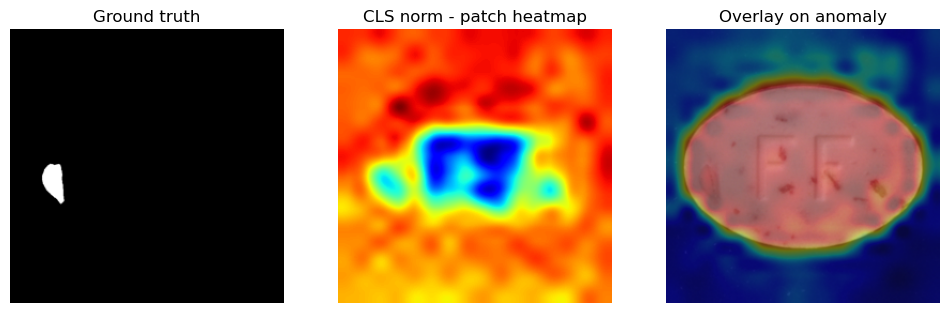

In [16]:
# Change path to your own directory of git folder
root_path = "/home/knudm/Documents/University/DTU/Semester 4/02456 - Deep Learning/ZeroShot_Anomaly_Detection_using_Vision_Foundation_Models/mvtec_anomaly_detection"
category = "pill"
anomaly = "contamination/006.png"
good_image_path   = f"{root_path}/{category}/train/good/000.png"
test_image_path   = f"{root_path}/{category}/test/{anomaly}"
ground_truth_path = f"{root_path}/{category}/ground_truth/{anomaly.replace('.png','_mask.png')}"


image_broken = Image.open(test_image_path).convert("RGB")
image_norm = Image.open(good_image_path).convert("RGB")
image_tensor_broken = pre_process(image_broken).unsqueeze(0)   # Add batch dim
image_tensor_normal = pre_process(image_norm).unsqueeze(0)

image_gnd_truth = Image.open(ground_truth_path).convert("RGB")

image_tensor_broken = image_tensor_broken.to(device)
image_tensor_normal = image_tensor_normal.to(device)
# image_gnd_truth.to(device)

visualize_patch_attention(image_tensor_broken, image_tensor_normal, image_gnd_truth, model, category)

In [128]:
def compute_final_heatmap(test_image_path, category, model, device, good_images=None):
    if good_images is None:
        all_good_samples = DataSampler.get_all_good_samples_from_category("mvtec", category)
        good_images = [sample['image'].unsqueeze(0) for sample in all_good_samples]
        good_images = torch.cat(good_images, dim=0)

    image_broken = Image.open(test_image_path).convert("RGB")
    image_tensor_broken = pre_process(image_broken).unsqueeze(0)   # Add batch dim
    image_tensor_broken = image_tensor_broken.to(device)

    final_heatmap = np.zeros((256,256))
    cls_heatmap = np.zeros((256,256))

    for i, good_image in enumerate(good_images):

        with torch.no_grad():
            features_dict = model.forward_features(image_tensor_broken)  # Usually outputs a tensor [1, 768] for vitb16
            #Also for the non-broken one
            features_dict_good = model.forward_features(good_image.unsqueeze(0).to(device))

        #Now we have a dictionary, with clstoken and a tensor. We only want the tensor.
        features = features_dict["x_norm_patchtokens"]
        # features_good = features_dict_good["x_norm_patchtokens"]

        #Save as a np.array, and then resize it, and show it.
        B, N, C = features.shape

        # 2. Reshape [16, 16, 384]
        H = W = int(N ** 0.5)
        tokens_grid = features.reshape(1, H, W, C)

        #Try similaitry to CLS tokens.
        cls = features_dict["x_norm_clstoken"]  # [1,384]
        cls = cls.expand_as(features[:, :N])
        cls_good = features_dict_good["x_norm_clstoken"]
        cls_good = cls_good.expand_as(features[:, :N])

        #sim = torch.einsum("nc,nc->n", features.squeeze(0), cls.squeeze(0)) #Dot product for each patch vs. the global cls token.
        #Try cosine similarity instead:
        sim = F.cosine_similarity(
            features.squeeze(0), 
            cls.squeeze(0), 
            dim=-1
        )
        sim_good = F.cosine_similarity(
            features.squeeze(0),
            cls_good.squeeze(0),
            dim =-1
        )

        heatmap = sim.reshape(H, W)
        heatmap_cls_good = sim_good.reshape(H,W)

        # 4. Normalize to [0, 1]
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
        heatmap_cls_good = (heatmap_cls_good - heatmap_cls_good.min()) / (heatmap_cls_good.max() - heatmap_cls_good.min())

        # 5. Upsample from 16×16 to 256×256 using PyTorch
        heatmap_up = F.interpolate(
            heatmap.unsqueeze(0).unsqueeze(0),  
            size=(256, 256),
            mode="bicubic",
            align_corners=False
        )[0, 0].cpu().numpy()

        heatmap_up_cls_good = F.interpolate(
            heatmap_cls_good.unsqueeze(0).unsqueeze(0),  
            size=(256, 256),
            mode="bicubic",
            align_corners=False
        )[0, 0].cpu().numpy()

        cls_heatmap += heatmap_up_cls_good

        better_heatmap = heatmap_up_cls_good - heatmap_up

        final_heatmap += better_heatmap
    
    return cls_heatmap, final_heatmap

In [123]:
root_path = "/home/knudm/Documents/University/DTU/Semester 4/02456 - Deep Learning/ZeroShot_Anomaly_Detection_using_Vision_Foundation_Models/mvtec_anomaly_detection"
category = "wood"

all_good_samples = DataSampler.get_all_good_samples_from_category("mvtec", category)
good_images = [sample['image'].unsqueeze(0) for sample in all_good_samples]
good_images = torch.cat(good_images, dim=0)

mvtec_anomaly_detection/wood/train
Found 247 good samples in category 'wood' of dataset 'mvtec'.


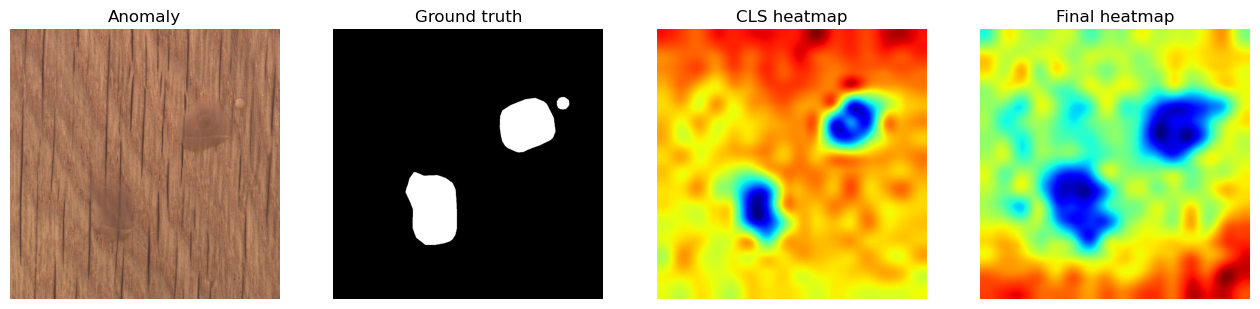

In [131]:
anomaly = "liquid/005.png"

test_image_path   = f"{root_path}/{category}/test/{anomaly}"
ground_truth_path = f"{root_path}/{category}/ground_truth/{anomaly.replace('.png','_mask.png')}"

cls_heatmap, final_heatmap = compute_final_heatmap(test_image_path, category, model, device, good_images=good_images)

# rescaling heatmaps to [0, 255]
cls_heatmap = (cls_heatmap - cls_heatmap.min()) / (cls_heatmap.max() - cls_heatmap.min()) * 255
cls_heatmap = cls_heatmap.astype(np.uint8)
final_heatmap = (final_heatmap - final_heatmap.min()) / (final_heatmap.max() - final_heatmap.min()) * 255
final_heatmap = final_heatmap.astype(np.uint8)

plt.figure(figsize=(16, 6))
plt.subplot(1, 4, 1); plt.title("Anomaly");       plt.imshow(Image.open(test_image_path).convert("RGB")); plt.axis("off")
plt.subplot(1, 4, 2); plt.title("Ground truth");  plt.imshow(Image.open(ground_truth_path).convert("RGB")); plt.axis("off")
plt.subplot(1, 4, 3); plt.title("CLS heatmap");   plt.imshow(cls_heatmap, cmap="jet", vmin=0, vmax=255); plt.axis("off")
plt.subplot(1, 4, 4); plt.title("Final heatmap"); plt.imshow(final_heatmap, cmap="jet", vmin=0, vmax=255); plt.axis("off")
plt.show()

In [75]:
# save final heatmap
cv2.imwrite("final_heatmap.png", final_heatmap)

True

In [76]:
from sklearn.metrics import f1_score

In [77]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

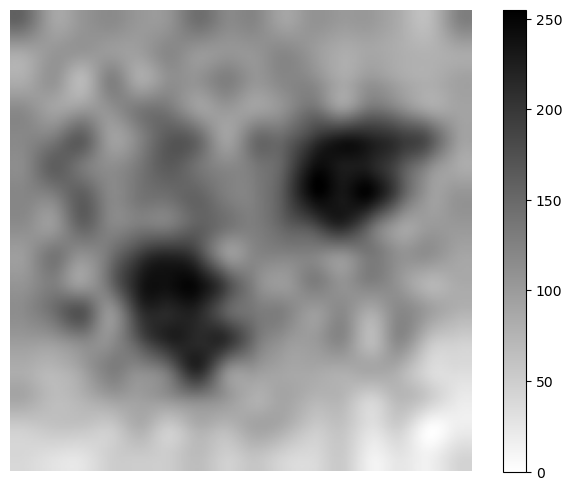

In [138]:
image = cv2.imread("final_heatmap.png")
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 6))
plt.imshow(image, cmap='binary')
plt.axis('off')
plt.colorbar()
plt.show()

In [ ]:
# test packages for peak detection
from skimage.feature import peak_local_max


In [79]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [80]:
masks = mask_generator.generate(image)

In [81]:
print(len(masks))
print(masks[0].keys())

2
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


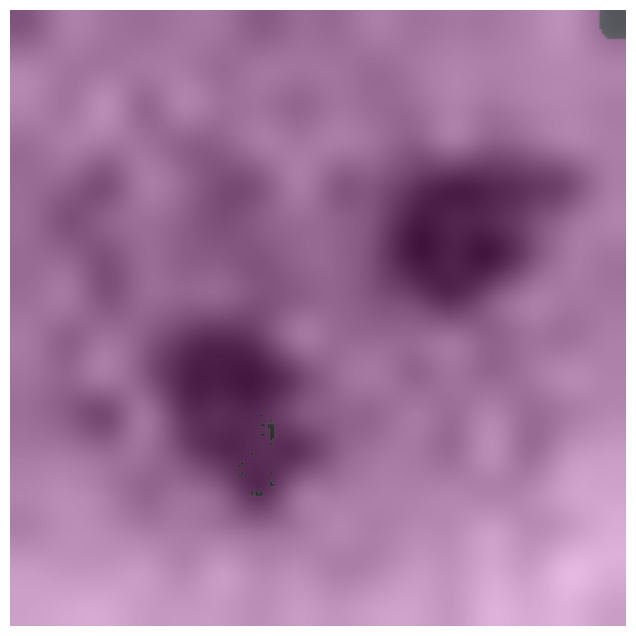

In [82]:
plt.figure(figsize=(8,8))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

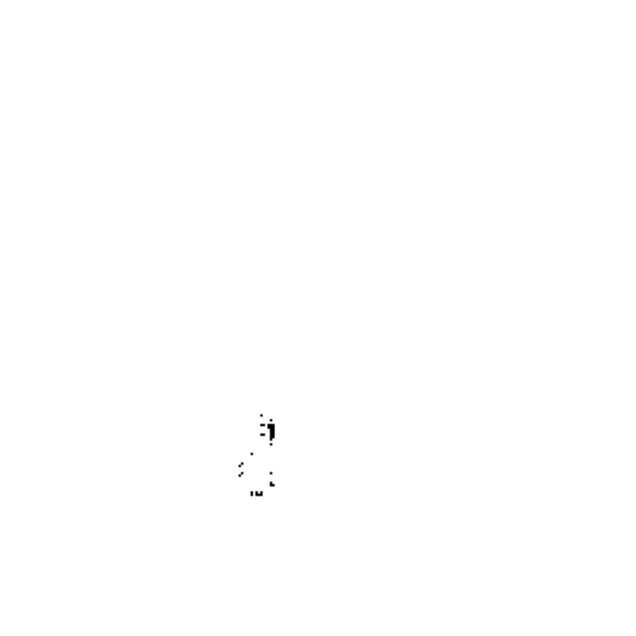

In [83]:
plt.figure(figsize=(8, 8))
plt.imshow(masks[0]['segmentation'], cmap='gray')
plt.axis('off')
plt.show()

In [84]:
image.shape

(256, 256, 3)

In [107]:
# find points in image below a certain threshold in heatmap
threshold = 100  # Adjust threshold as needed
points = np.column_stack(np.where(final_heatmap < threshold))
points.shape

(9855, 2)

In [101]:
predictor = SamPredictor(sam)

predictor.set_image(image)

input_point = np.array([[170, 100]])
input_label = np.array([1])

In [102]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

In [103]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

In [104]:
masks.shape

(1, 256, 256)

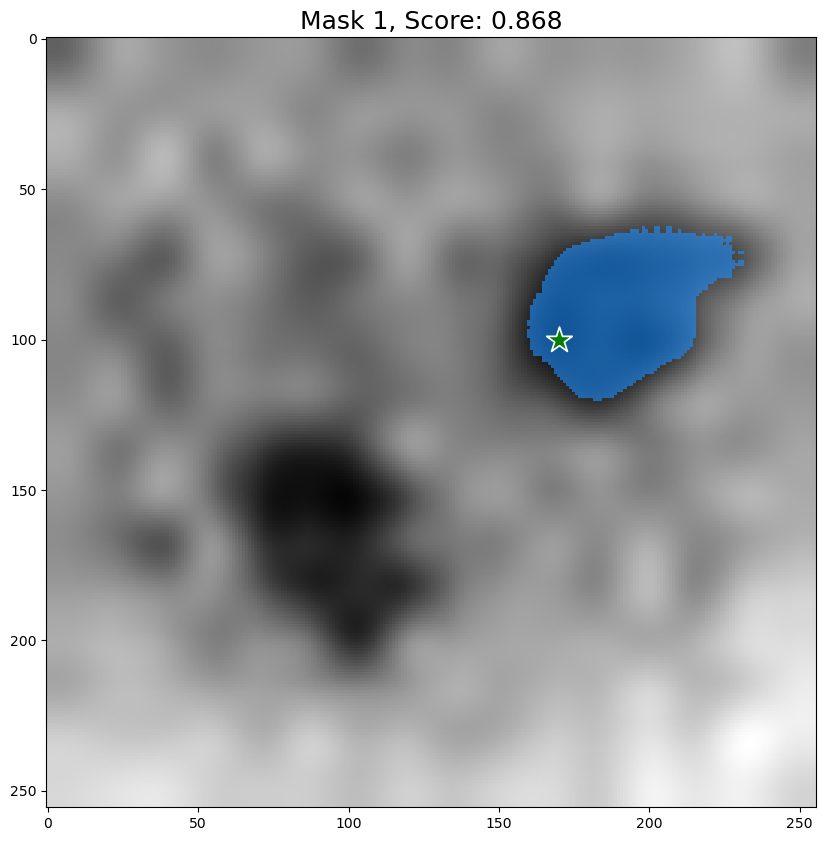

In [105]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.show()